In [1]:
import numpy as np
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
requested_1 = 3
requested_2 = 4
returned_1 = 3
returned_2 = 2
mu = [requested_1, requested_2, returned_1, returned_2]

y = 0.9

max_cars = 20
max_overtake = 5

rew_down = -2
rew_up = 10

In [3]:
def car_interval(mu, e):
    for i in range(max_cars+1):
        if poisson.pmf(i, mu) > e:
            start = i
            for j in range(i, max_cars+1):
                if poisson.pmf(j, mu) < e:
                    end = j-1
                    return range(start, end+1)
                elif j == max_cars:
                    return range(start, max_cars+1)
    return range(0, 0)

In [4]:
# Расмматриваем количество арендованных и возвращенных машин, для которых вероятность появления больше e
e = 0.01
int_req_1 = car_interval(requested_1, e)
int_ret_1 = car_interval(returned_1, e)
int_req_2 = car_interval(requested_2, e)
int_ret_2 = car_interval(returned_2, e)

In [5]:
values = np.zeros((max_cars + 1, max_cars + 1))
policy = np.zeros((max_cars + 1, max_cars + 1)).astype(int)

In [6]:
# оценка ценности

def new_value(state, action, values):
    
    new_state = [min(state[0]-action, max_cars), min(state[1]+action, max_cars)] 
    v = abs(action)*rew_down # затраты на перегон машин
    
    for out_1 in int_req_1:
        for out_2 in int_req_2:
            for in_1 in int_ret_1:
                for in_2 in int_ret_2:
                    n = [out_1, out_2, in_1, in_2] # количество арендованных и возвращенных машин в 1 и 2 офисах
                    p = np.prod(poisson.pmf(n, mu)) # вероятность комбинации n
            
                    # сколько машин было сдано в аренду в 1 и 2 офисах
                    cars_req1 = min(out_1, new_state[0])
                    cars_req2 = min(out_2, new_state[1])
            
                    # прибыль за аренду
                    reward = (cars_req1 + cars_req2) * rew_up
                    
                    # сколько машин осталось после возвращения машин
                    cars_ret1 = min(new_state[0] - cars_req1 + in_1, max_cars)
                    cars_ret2 = min(new_state[1] - cars_req2 + in_1, max_cars)

                    v += p * (reward + y * values[cars_ret1, cars_ret2])
    return v

In [7]:
# оценивание стратегии

def policy_evoluation(values, Q):
    dif = 1
    err = []
    while dif > Q:
        old_values = values.copy()
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                action = policy[i, j]
                values[i, j] = new_value([i, j], action, values)
        dif = abs(old_values-values).max()
        err.append(dif)
    return values, err

In [8]:
# улучшение стратегии

def policy_improvement(policy, values):
    old_policy = policy.copy()
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            
            act_min = max(-j, -5)
            act_max = min(5, i) + 1
            all_values = {}
            
            for action in range(act_min, act_max):
                all_values[action] = new_value([i, j], action, values)
            new_action = max(all_values, key=all_values.get)
            policy[i, j] = new_action
    if (policy == old_policy).all():
        return True
    else:
        return False

In [9]:
%%time

all_policy = [policy.copy()]
errors = []
while True:
    Q = 0.01
    values, err = policy_evoluation(values, Q)
    errors.append(err)
    condition =  policy_improvement(policy, values)
    all_policy.append(policy.copy())
    if condition:
        break

Wall time: 4h 54min 40s


Text(0.5, 1.0, 'values*')

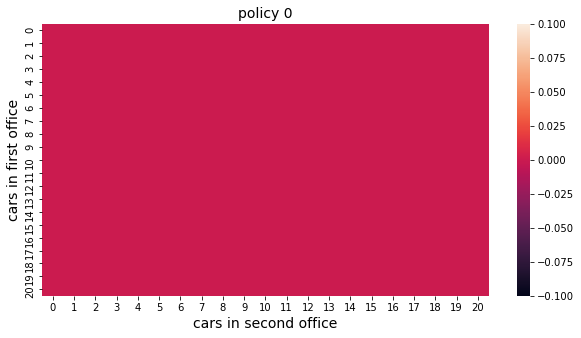

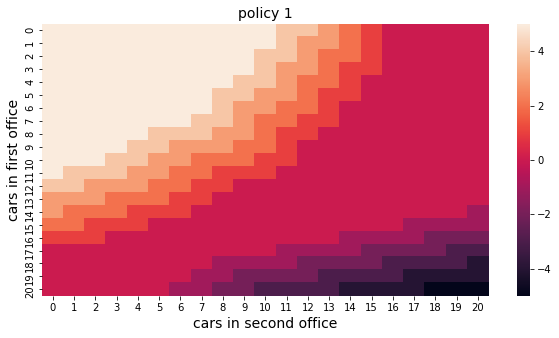

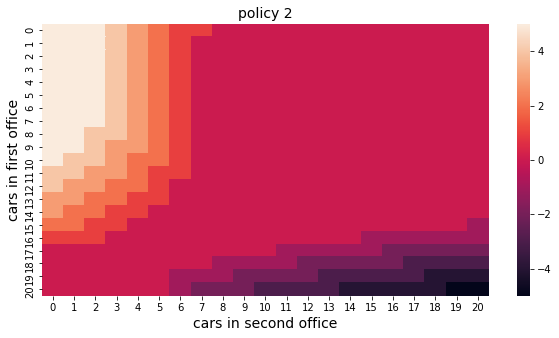

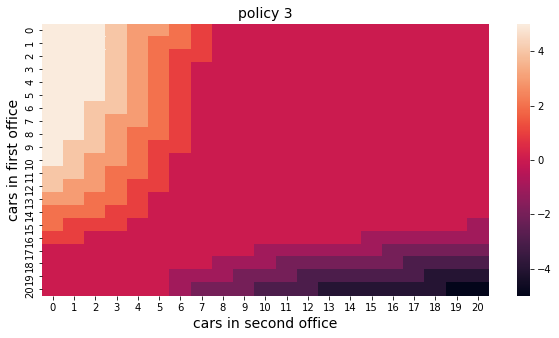

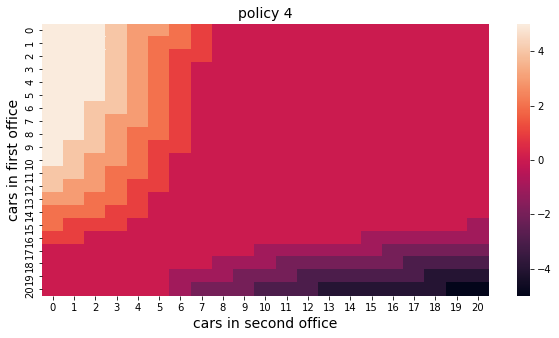

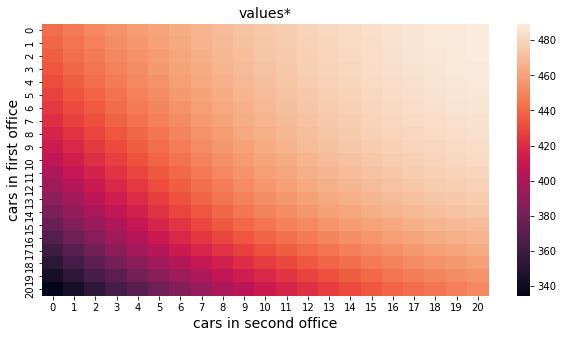

In [11]:
for i in range(len(all_policy)):
    _, axes = plt.subplots(figsize=(10, 5))
    fig = sns.heatmap(np.flipud(all_policy[i]))
    fig.set_ylabel('cars in first office', fontsize=14)
    fig.set_xlabel('cars in second office', fontsize=14)
    fig.set_title('policy {}'.format(i), fontsize=14)

_, axes = plt.subplots(figsize=(10, 5))
fig = sns.heatmap(np.flipud(values))
fig.set_ylabel('cars in first office', fontsize=14)
fig.set_xlabel('cars in second office', fontsize=14)
fig.set_title('values*', fontsize=14)

In [12]:
errors

[[141.94142240633806,
  100.44594350251973,
  71.90321615670408,
  55.78464466507572,
  43.94952025209426,
  34.05935732203733,
  26.235376418224405,
  20.183802577395227,
  15.885558527390117,
  12.5447376989203,
  9.87201185913085,
  7.745175892676798,
  6.060195814982592,
  4.730425830665638,
  3.684589861375116,
  2.864577620558407,
  2.22336918388379,
  1.7231728832473436,
  1.3337953693527425,
  1.0312410794776383,
  0.7965280061707745,
  0.6147004188215988,
  0.47401579752107637,
  0.3652821946610061,
  0.2813229405574589,
  0.2165474245821315,
  0.1666090802260669,
  0.1281342931865197,
  0.09850848399742063,
  0.07570794680884774,
  0.058168084847523005,
  0.04468045086036909,
  0.03431248718175084,
  0.026345089396897947,
  0.020224121815772378,
  0.015522825512050531,
  0.011912710842466367,
  0.009141046123772867],
 [48.535224914222454,
  1.1075533251969887,
  0.5446500102281675,
  0.4117789850972713,
  0.345899650510205,
  0.27716419162607053,
  0.21575562468194676,
  0.16